# OpenCV for Feature Detection and Description


[画像処理の数式を見て石になった時のための、金の針](http://qiita.com/icoxfog417/items/adbbf445d357c924b8fc)のサンプルコードになります。以下の処理について、実際OpenCVを使って実装してみます。

* Harris Corner Detectionによるコーナー検出
* SIFTによる特徴点検出
* SIFTによる特徴点のマッチング


In [1]:
# enable showing matplotlib image inline
%matplotlib inline

IMAGE_PATH = "./images/cat.PNG"
MATCH_TARGET = "./images/face.PNG"
MATCH_AREA = "./images/office.PNG"

## Harris Corner Detection

OpenCVを使い、実際にコーナー検出を行ってみます。

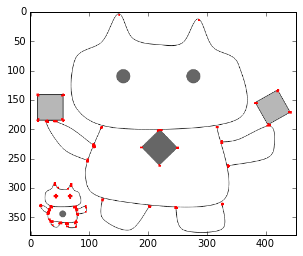

In [2]:
def harris(path):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    grayed = np.float32(grayed)
    
    # cv2.cornerHarris(src, blockSize, ksize, k)
    # blockSize: 指定したサイズの領域(2なら、2*2の領域)の変化量を合計してMを計算
    # ksize: Sobelフィルタのサイズ
    # k: Rを計算するときのkの値。0.04~0.06くらい
    R = cv2.cornerHarris(grayed, 2, 3, 0.04)
    
    # 検出したコーナーを目立つようにするため、近傍の最大値を適用する(コーナーの範囲が大きくなるようなイメージ)
    R = cv2.dilate(R, None)
    
    # 閾値以上のコーナーの色を赤にする
    img[R > 0.01 * R.max()] = [255, 0, 0]
    
    plt.imshow(img)

harris(IMAGE_PATH)

検出された結果のポイントとしては以下になります。

* 両手に持った四角のcornerが、回転しているにもかかわらず検出されている
* 小さい猫の方が検出数が多い。Harrisがスケールに対しては頑健でないという特徴がよく分かると思います。

では、これをSIFTで行うとどうなるかを見ていきたいと思います。


## SIFTによる特徴点検出

同じ検出をSIFTで試してみます。


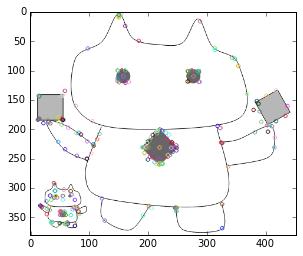

In [3]:
def sift(path):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=4, sigma=1.0)
    points = sift.detect(grayed, None)
    
    img = cv2.drawKeypoints(grayed, points, None)
    plt.imshow(img)

sift(IMAGE_PATH)

拡大した猫のエッジもしっかり検出できているのが分かります。
ただ、octaveやsigmaといったパラメーターを結構いじってやらないとうまく検知できません。こうしたパラメーターを調整する際も、パラメーターが一体何を意味しているのかが分からないと調整できないと思うので、本文がそうした理解の参考になればと思います。


## SIFTによる特徴点のマッチング

SIFTでは、検出した特徴点を表す128次元のベクトルを作成できます。最後に、このベクトルを使用して画像のマッチング処理を行ってみます。


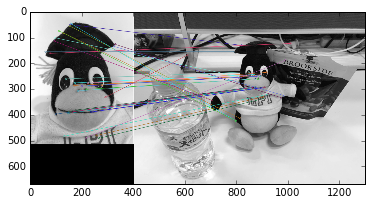

In [4]:
def sift_match(target, area):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    
    def read_as_gray(path):
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return gray
    
    img_target = read_as_gray(target)
    img_area = read_as_gray(area)
    
    sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=4)
    
    # 特徴点の検出
    kp_t, des_t = sift.detectAndCompute(img_target, None)
    kp_a, des_a = sift.detectAndCompute(img_area, None)
    
    # Brute-Forceでマッチング
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_t, des_a, k=2)
    
    # 良くマッチした点を表示
    good = [m for m, n in matches if m.distance < 0.75 * n.distance]
    matching = cv2.drawMatches(img_target, kp_t,img_area, kp_a, good, None, flags=2)
    
    plt.imshow(matching)
    
sift_match(MATCH_TARGET, MATCH_AREA)

顔近辺はなんとなく一致しているかな・・・という気がしますが、似た色・場所があるとやはり間違ったりもするようです。

